In [1]:
import numpy as np
import theano.tensor as T
from lasagne.layers import *
from lasagne.nonlinearities import *
from lasagne.objectives import *
from lasagne.updates import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from visualize import draw_to_file
from IPython.display import Image

In [3]:
import load_mnist

In [4]:
np.load("./mnist_sequence1_sample_5distortions5x5.npz")

In [5]:
mc = np.load("./mnist_sequence1_sample_5distortions5x5.npz")
#X_train, y_train, X_valid, y_valid, _, _ = load_mnist.load_dataset()
X_train, y_train, X_valid, y_valid = mc['X_train'], mc['y_train'], mc['X_valid'], mc['y_valid']
X_train = X_train.reshape((-1, 1, 40, 40))
X_valid = X_valid.reshape((-1, 1, 40, 40))
y_train = y_train.flatten()
y_valid = y_valid.flatten()

----------

In [6]:
def get_layer_with_tag(l_out, tag):
    for layer in get_all_layers(l_out):
        if hasattr(layer, 'tag') and layer.tag==tag:
            return layer
    return None

In [7]:
def get_net():
    l_in = InputLayer((None, 1, 40, 40))
    conv = l_in
    conv = batch_norm(Conv2DLayer(conv, num_filters=32, filter_size=3, stride=2))
    conv = batch_norm(Conv2DLayer(conv, num_filters=48, filter_size=3, stride=1))
    conv = batch_norm(Conv2DLayer(conv, num_filters=64, filter_size=3, stride=1))
    conv = batch_norm(Conv2DLayer(conv, num_filters=96, filter_size=3, stride=1))
    conv.tag = "fm"
    conv = Pool2DLayer(conv, pool_size=conv.output_shape[-1], mode='average_inc_pad')
    conv = FlattenLayer(conv)
    conv = DenseLayer(conv, num_units=10, nonlinearity=softmax)
    conv.tag = "dense"
    return conv
    
    #return {'in':l_in, 'out':out, 'code':code, 'eps':l_eps}

In [8]:
l_out = get_net()
for layer in get_all_layers(l_out):
    print layer, layer.output_shape
count_params(l_out)

<lasagne.layers.input.InputLayer object at 0x1147f2d10> (None, 1, 40, 40)
<lasagne.layers.conv.Conv2DLayer object at 0x11480f490> (None, 32, 19, 19)
<lasagne.layers.normalization.BatchNormLayer object at 0x113b5c310> (None, 32, 19, 19)
<lasagne.layers.special.NonlinearityLayer object at 0x118596950> (None, 32, 19, 19)
<lasagne.layers.conv.Conv2DLayer object at 0x118596ad0> (None, 48, 17, 17)
<lasagne.layers.normalization.BatchNormLayer object at 0x118596d10> (None, 48, 17, 17)
<lasagne.layers.special.NonlinearityLayer object at 0x1185a01d0> (None, 48, 17, 17)
<lasagne.layers.conv.Conv2DLayer object at 0x1185a0350> (None, 64, 15, 15)
<lasagne.layers.normalization.BatchNormLayer object at 0x1185a0590> (None, 64, 15, 15)
<lasagne.layers.special.NonlinearityLayer object at 0x1185a0a10> (None, 64, 15, 15)
<lasagne.layers.conv.Conv2DLayer object at 0x1185a0b90> (None, 96, 13, 13)
<lasagne.layers.normalization.BatchNormLayer object at 0x1185a0dd0> (None, 96, 13, 13)
<lasagne.layers.special.No

98986

In [9]:
draw_to_file(get_all_layers(l_out), "graph.png", verbose=True)

---------

In [10]:
x = T.tensor4('x')
y = T.ivector('y')
net_out = get_output(l_out, x)

In [11]:
loss = categorical_crossentropy(net_out, y).mean()

In [12]:
params = get_all_params(l_out, trainable=True)

In [13]:
updates = adam(loss, params)

-------

In [14]:
def iterator(xx, yy, bs, shuffle=True):
    if shuffle:
        idxs = np.arange(0, xx.shape[0])
        np.random.shuffle(idxs)
        xx, yy = xx[idxs], yy[idxs]
    for b in range( (xx.shape[0] // bs) + 1 ):
        if xx[b*bs:(b+1)*bs].shape[0]==0:
            break
        yield xx[b*bs:(b+1)*bs], yy[b*bs:(b+1)*bs]

In [15]:
train_fn = theano.function([x,y], loss, updates=updates, on_unused_input='warn')

In [16]:
net_out_det = get_output(l_out, x, deterministic=True)
out_fn = theano.function([x], net_out_det)

In [17]:
for epoch in range(0,100):
    losses = []
    for x_batch, y_batch in iterator(X_train, y_train, 32):
        aa = train_fn(x_batch, y_batch)
        losses.append(aa)
    print epoch+1, np.mean(losses)

1 0.900928335481
2 0.290510298232
3 0.182899623259
4 0.130938750268


KeyboardInterrupt: 

In [23]:
import cPickle as pickle
with open("wts.pkl", "wb") as f:
    pickle.dump(get_all_param_values(l_out), f)

---------

In [24]:
preds = []
for x_batch, y_batch in iterator(X_valid, y_valid, 32, shuffle=False):
    preds += np.argmax(out_fn(x_batch),axis=1).tolist()
print (preds==y_valid).mean()

0.966


In [25]:
from skimage.transform import resize

In [26]:
fm_out = get_output(get_layer_with_tag(l_out, 'fm'), x, deterministic=True)

In [27]:
fn_fm = theano.function([x], fm_out)

In [41]:
inv_ = InverseLayer(l_out, l_out.input_layer)
inv_.output_shape

(None, 96, 1, 1)

In [28]:
'''
def plot_fms(inp, resize_to=(28,28), figsize=(10,10)):
    assert inp.shape[0] == 1
    this_fms = fn_fm(inp)[0]
    plt.figure(figsize=figsize)
    for i in range(this_fms.shape[0]):
        this_fm_resized = resize(this_fms[i], output_shape=resize_to)
        plt.subplot(1, this_fms.shape[0], i+1)
        plt.imshow(this_fm_resized)
        plt.axis('off')
'''

"\ndef plot_fms(inp, resize_to=(28,28), figsize=(10,10)):\n    assert inp.shape[0] == 1\n    this_fms = fn_fm(inp)[0]\n    plt.figure(figsize=figsize)\n    for i in range(this_fms.shape[0]):\n        this_fm_resized = resize(this_fms[i], output_shape=resize_to)\n        plt.subplot(1, this_fms.shape[0], i+1)\n        plt.imshow(this_fm_resized)\n        plt.axis('off')\n"

In [34]:
x_batch = X_train[0:32]


In [31]:
tmp10 = np.random.normal(0,1,size=(10,10))
print tmp10*(tmp10>0)

[[-0.          0.60207576 -0.         -0.          0.66885249 -0.         -0.
   1.25475447  1.01036868 -0.        ]
 [-0.          0.39611457 -0.         -0.          0.31966633 -0.         -0.
   0.15476757 -0.          1.88910817]
 [-0.         -0.          1.76424144  0.50088428  1.16093954 -0.
   0.59066348 -0.          0.75549622  1.77944915]
 [-0.          0.07537664 -0.          1.41049574  0.13473575 -0.
   0.55415373 -0.         -0.         -0.        ]
 [ 0.16862117 -0.         -0.          0.98675464  0.38999022  0.86986252
   0.78790087  1.2853711  -0.          0.92644741]
 [ 0.33533801 -0.         -0.          2.07835466  0.1399148   1.86251866
   0.25727455  0.63114846  0.48057539  0.69168942]
 [-0.         -0.         -0.         -0.         -0.          1.17648978
   0.47770056 -0.          1.06646656 -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
   1.23666085 -0.         -0.         -0.        ]
 [-0.         -0.          1.13673495 -0

In [32]:
def plot_fm_for_class(inp, wts, resize_to, figsize=(10,10), plot=True):
    assert inp.shape[0] == 1
    num_classes = wts.shape[1]
    this_fms = fn_fm(inp)[0]
    if plot:
        plt.figure(figsize=figsize)
        plt.subplot(1, num_classes+1, 1)
        plt.imshow(inp[0][0])
        plt.axis('off')
    fms = []
    for k in range(num_classes):
        # create the weighted feature map for class k
        result = np.zeros_like(this_fms[0])
        for i in range(this_fms.shape[0]):
            # multiply the i'th feature map by the i'th weight for class k
            this_fm_weighted = this_fms[i]*(wts[i,k]**2)
            result += this_fm_weighted
        # then apply relu
        result = result*(result>0)
        #print np.min(result), np.max(result)
        result = (result - np.max(result)) / (np.max(result) - np.min(result))
        this_fm_resized = resize(result, output_shape=resize_to)
        #if debug:
        #    print "magnitute for class %i = %f" % (k, np.sum(this_fm_resized))
        this_fm_resized = (this_fm_resized - np.min(this_fm_resized)) / (np.max(this_fm_resized)-np.min(this_fm_resized))
        if plot:
            plt.subplot(1, num_classes+1, k+2)
            plt.imshow(this_fm_resized)
            plt.title(str(k))
            plt.axis('off')
        fms.append(this_fm_resized)
    if not plot:
        return fms

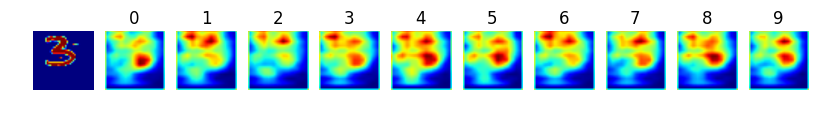

In [35]:
plot_fm_for_class(x_batch[11:12], wts=l_out.W.get_value(), resize_to=(40,40) )

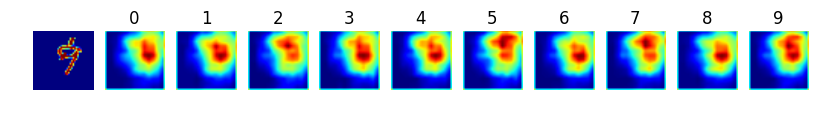

In [36]:
plot_fm_for_class(x_batch[0:1], wts=l_out.W.get_value(), resize_to=(40,40) )

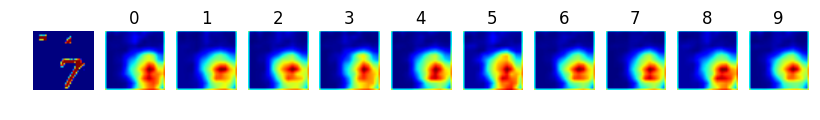

In [37]:
plot_fm_for_class(X_train[101:102], wts=l_out.W.get_value(), resize_to=(40,40) )

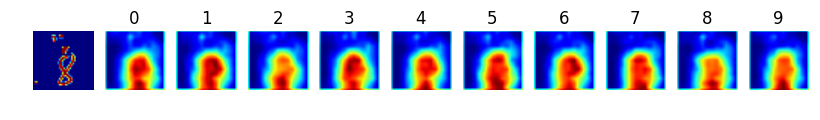

In [38]:
plot_fm_for_class(X_train[102:103], wts=l_out.W.get_value(), resize_to=(40,40) )

-----

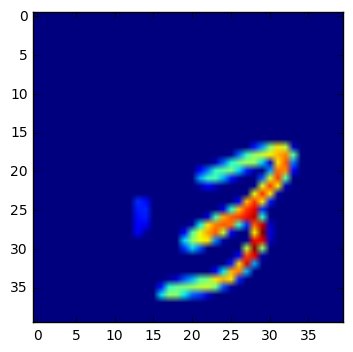

In [88]:
this_idx = 116
plt.imshow(
    plot_fm_for_class(X_train[this_idx][np.newaxis], wts=l_out.W.get_value(), plot=False, resize_to=(40,40) )[0]
    *
    X_train[this_idx][np.newaxis][0][0]
)

In [46]:
this_wts = l_out.W.get_value()[:,0]
this_fms = fn_fm(X_train[102:103])[0]
result = np.zeros(())
for j in range(this_fms[0]):
    

(96,)